### Importing required Liabraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from copy import deepcopy
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

### Loading data
* Loaded data into train and test Dataframes.
* Seperated categorical feature names and Numerical feature names.
* Implemented label encoding
* Handled categorical features having different unique values in train and test data as below:
    * Created an array of unique values of specific feature which is present in either train or test data but not in both.
    * Implemented SearchFeature function such that it will return variable if it should be removed , NaN otherwise.
    * Used pandas.factorize() to replace all categorical variables by integers and NaN by -1.

In [2]:
trainData = pd.read_csv('train.csv',nrows=188318)
testData = pd.read_csv('test.csv')

print('Shape of train data: ',trainData.shape)
print('Shape of test data: ',testData.shape)

print('Joining train and test data')
testData['loss'] = np.nan
data = pd.concat([trainData,testData])
print('Joining completed!')
print('Shape of concatenated data: ',data.shape)

catFeat = list(trainData.select_dtypes(include=['object']).columns)
print('Total number of categorical features: ',len(catFeat))

Shape of train data:  (188318, 132)
Shape of test data:  (125546, 131)
Joining train and test data
Joining completed!
Shape of concatenated data:  (313864, 132)
Total number of categorical features:  116


In [3]:
noCommon = []
for i in catFeat:
    if trainData[i].nunique() != testData[i].nunique():
        noCommon.append(i)
print('Features that have diff unique values in train and test are :')
print(noCommon)

Features that have diff unique values in train and test are :
['cat90', 'cat92', 'cat96', 'cat99', 'cat101', 'cat102', 'cat103', 'cat105', 'cat106', 'cat109', 'cat110', 'cat113', 'cat114', 'cat116']


In [4]:
def searchFeature(x):
    if x in combinedRemaining:
        return np.nan
    return 

for i in catFeat:
    if trainData[i].nunique() != testData[i].nunique():
        trainUnique = set(trainData[i].unique())
        testUnique  = set(testData[i].unique())
        remainingTrain  = trainUnique - testUnique
        remainingTest   = testUnique - trainUnique
        
        combinedRemaining = remainingTrain.union(remainingTest)
        
        data[i] = data[i].apply(lambda x: searchFeature(x),1)
    data[i] = pd.factorize(data[i].values,sort = True)[0]

In [5]:
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,0,1,0,1,0,0,0,0,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## Making data Model ready

In [6]:
xTrain = data[data['loss'].notnull()]
xTest = data[data['loss'].isnull()]

shift = 100
yTrain = np.log(xTrain['loss'] + shift)
xTrain = xTrain.drop(['id','loss'],axis = 1)
xTest = xTest.drop(['id','loss'],axis = 1)

print('Shape of train data: ',xTrain.shape)
print('Shape of test data: ',xTest.shape)

Shape of train data:  (188318, 130)
Shape of test data:  (125546, 130)


### A function to run multiple models
* We will train muliple models on train dataset without any hyperparameter tuning.
* Then we will calculate model performance on cross validation dataset.
* We will select best model from these models as primary model.

In [7]:
def runModels(xTrain,yTrain,xCV,yCV):
    """
    This function traings multiple models on train dataset and calculates and returns model performance for each model
    """
    # Defining models
    modelLR = LinearRegression()
    modelRF = RandomForestRegressor()
    modelDT = DecisionTreeRegressor()
    modelGBD = GradientBoostingRegressor()
    modelKNN = KNeighborsRegressor()
    modelADB = AdaBoostRegressor()
    modelXGB = XGBRegressor()
    modelRidge = Ridge()
    modelLasso = Lasso()
    modelElastic = ElasticNet()
    
    models = [modelLR, modelRF, modelDT, modelGBD, modelKNN, modelADB, modelXGB, modelRidge, modelLasso, modelElastic]
    modelPerf = {}
    
    print('Training models...')
    start = time.time()
    for model in models:
        model.fit(xTrain,yTrain)
        pred = model.predict(xCV)
        #Compute score
        mae = mean_absolute_error(np.exp(yCV),np.exp(pred))
        modelPerf.update({model:mae})
    end = time.time()
    print('Training complete! Time elapsed {0} seconds.'.format(end-start))
    
    return modelPerf

### Splitting the data

In [8]:
#Train test split
xTrain1, xCV1, yTrain1, yCV1 = train_test_split(xTrain,yTrain,test_size = 0.2)

In [9]:
modelPerf = runModels(xTrain1,yTrain1,xCV1,yCV1)

Training models...
Training complete! Time elapsed 861.630585193634 seconds.


### Histogram distribution of MAE of all the models

Text(0.5, 1.0, 'Zoomed Model Vs Mean Absolute Error')

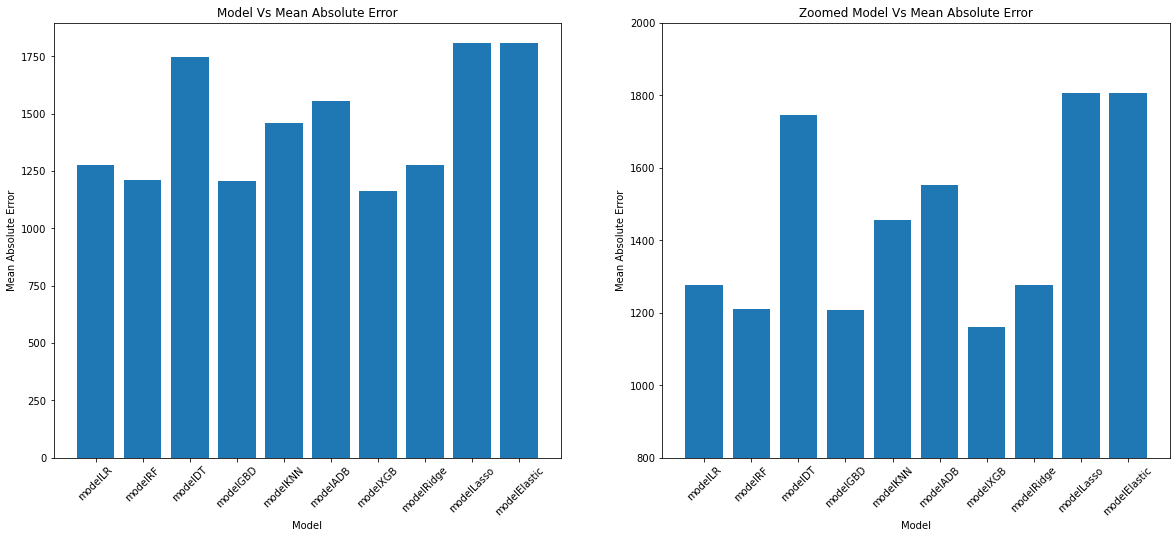

In [10]:
models = ['modelLR', 'modelRF', 'modelDT', 'modelGBD', 'modelKNN', 'modelADB', 'modelXGB', 'modelRidge', 'modelLasso', 'modelElastic']
error = modelPerf.values()

fig, (plt1,plt2) = plt.subplots(1,2)
fig.set_size_inches(20,8)

plt1.bar(models,error)
plt1.set_xticklabels(models,rotation=45)
plt1.set_xlabel('Model')
plt1.set_ylabel('Mean Absolute Error')
plt1.set_title('Model Vs Mean Absolute Error')

plt2.bar(models,error)
plt2.set_ylim(800,2000)
plt2.set_xticklabels(models,rotation=45)
plt2.set_xlabel('Model')
plt2.set_ylabel('Mean Absolute Error')
plt2.set_title('Zoomed Model Vs Mean Absolute Error')

In [11]:
print(error)

dict_values([1277.7614423118214, 1211.2851472215646, 1744.5993330501274, 1207.556964670193, 1457.1196422580138, 1552.8859727149224, 1160.4368701383191, 1277.7538759353229, 1805.3472592480218, 1805.3472592480218])


### Observations:
* Trained multiple regression models without any hyperparameter tuning.
* Some of the models performed well but some of the performed worst as input data has 130 dimensions and not all the modelsperform well for high dimensional data
* XGBOOST performed well even without any hyperparameter tuning.

### Using OneHot Encoding

In [12]:
dataOHE = pd.get_dummies(data=trainData, columns=catFeat)
dataOHE.reset_index(drop = True, inplace = True)
print('Shape of data after OHE :',dataOHE.shape)

x_train = dataOHE.drop(['id','loss'],axis =1)
y_train = np.log(dataOHE['loss'])

x_train_ohe,x_cv_ohe,y_train_ohe,y_cv_ohe = train_test_split(x_train,y_train,test_size = 0.2)

Shape of data after OHE : (188318, 1155)


### Training XGBRegressor on one hot encoded features

In [13]:
model = XGBRegressor(n_jobs=-1)
model.fit(x_train_ohe,y_train_ohe)
pred =  model.predict(x_cv_ohe)
err = mean_absolute_error(np.exp(y_cv_ohe), np.exp(pred))
print('Mean Absolute Error of XGBRegressor with One Hot Encoding: ',err)

Mean Absolute Error of XGBRegressor with One Hot Encoding:  1155.8194350259953


### Observations:
* We can notice that XGBRegressor with label encoded features perfroms better than XGBRegressor with one hot encoded features

### Hyper parameter tuning

In [14]:
start = time.time()
params1 = {'max_depth':[11,12,13], 'min_child_weight':range(1,3)}
clf = XGBRegressor(learning_rate =0.01, n_estimators=1000, max_depth=5,
                min_child_weight=1, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                scale_pos_weight=1, seed=0)

model1 = GridSearchCV(estimator=clf,param_grid = params1)
model1.fit(xTrain1,yTrain1)
print('Fisrt hyper parameter tune results:',model1.best_params_)
end = time.time()
print('Training complete! Time elapsed {0} seconds.'.format(end-start))

Fisrt hyper parameter tune results: {'max_depth': 11, 'min_child_weight': 2}
Training complete! Time elapsed 27017.814440250397 seconds.


In [18]:
start = time.time()
params2 = {'learning_rate':[0.01,0.1,0,1], 'gamma':[0.1,1,1.02]}

clf = XGBRegressor(learning_rate =0.01, n_estimators=1000, max_depth=11,
                min_child_weight=2, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                scale_pos_weight=1, seed=0)
model2 = GridSearchCV(estimator=clf,param_grid = params2)
model2.fit(xTrain1,yTrain1)
print('Second hyper parameter tune results:',model2.best_params_)
end = time.time()
print('Training complete! Time elapsed {0} seconds.'.format(end-start))

Second hyper parameter tune results: {'gamma': 1.02, 'learning_rate': 0.01}
Training complete! Time elapsed 45730.78299546242 seconds.


In [19]:
start = time.time()
params3 = {'colsample_bytree': [0.5,0.6,0.7], 'subsample' :[0.9,0.8,0.7]}

clf = XGBRegressor(learning_rate =0.01, n_estimators=1000, max_depth=11,
                min_child_weight=2, gamma=0.005, subsample=0.9, colsample_bytree=0.75,
                scale_pos_weight=1, seed=0)

model3 = GridSearchCV(estimator =clf,param_grid = params3)
model3.fit(xTrain1,yTrain1)
print('Third hyper parameter tune results:',model3.best_params_)
end = time.time()
print('Training complete! Time elapsed {0} seconds.'.format(end-start))

Third hyper parameter tune results: {'colsample_bytree': 0.6, 'subsample': 0.9}
Training complete! Time elapsed 51685.39808797836 seconds.


### Training best model with best parameters

In [20]:
start = time.time()
print('Training model with best parameters...')
modelFinal = XGBRegressor(n_estimators=1000,learning_rate=0.1,max_depth=11,min_child_weight=2,gamma=1.02,subsample=0.9,colsample_bytree=0.6)
modelFinal.fit(xTrain1,yTrain1)
end = time.time()
print('Training complete! Time elapsed {0} seconds.'.format(end-start))

pred = modelFinal.predict(xCV1)
mae = mean_absolute_error(np.exp(yCV1),np.exp(pred))
print('Mean Absolute error of best model: ',mae)

Training model with best parameters...
Training complete! Time elapsed 617.328694820404 seconds.
Mean Absolute error of best model:  1155.4722401381875


In [21]:
def xgboostEvalMAE(pred,dTrain):
    labels = dTrain.get_label()
    a = mean_absolute_error(np.exp(pred),np.exp(labels))
    return 'MAE',a

In [23]:
# Finding best rounds via cross validate xgboost with 50 early stoppings.
RANDOM_STATE = 2000
params = {
        'min_child_weight': 2,
        'eta': 0.01,
        'colsample_bytree': 0.6,
        'learning_rate': 0.1,
        'max_depth': 11,
        'subsample': 0.9,
        'alpha': 1,
        'gamma': 1.02,
        'seed': RANDOM_STATE
    }

xgTrain = xgb.DMatrix(xTrain, label=yTrain)
xgTest = xgb.DMatrix(xTest)

res = xgb.cv(params, xgTrain, num_boost_round=2500, nfold=5, stratified=False,
         early_stopping_rounds=50, verbose_eval=500, show_stdv=True, feval=xgboostEvalMAE, maximize=False)

In [24]:
best_nrounds = res.shape[0] - 1
cvMean = res.iloc[-1, 0]
cvStd = res.iloc[-1, 1]
print('Ensemble CV: {0}+{1}'.format(cvMean, cvStd))
print('Best n rounds are :',best_nrounds)

Ensemble CV: 0.4327426+0.0005877617204275927
Best n rounds are : 208


In [27]:
RANDOM_STATE = 2016

xgTrain = xgb.DMatrix(xTrain, label=yTrain)
xgTest = xgb.DMatrix(xTest)

model = xgb.train(params, xgTrain,best_nrounds, feval=xgboostEvalMAE)

prediction = np.exp(model.predict(xgTest)) - shift

sub = pd.read_csv('sample_submission.csv')
sub['loss'] = prediction
sub.to_csv('submissions2.csv', index=False)
